In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, truncnorm, norm
import pandas as pd
import os
from scipy.special import erf, owens_t
from scipy.stats import norm
from scipy.special import owens_t

# Parameters


# Data directory
wrd =r"C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research"


# Calculate Patent Value for multiple patent days

In [2]:
# Read the Stata file

#Save Pat Pub Citation Pair File
filename =os.path.join(wrd,"Data\kpss_calculation\patent_science_python_topq_fullSample.dta")
print(filename)

data = pd.read_stata(filename)


#data = pd.read_stata(r"C:\Users\jayho\OneDrive - Duke University\KPSS_Replication\ABF_PatValue_Research\Data\patent_science_python_jay.dta")

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1424605069.py:4: SyntaxWarning: invalid escape sequence '\k'
  filename =os.path.join(wrd,"Data\kpss_calculation\patent_science_python_topq_fullSample.dta")


C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\kpss_calculation\patent_science_python_topq_fullSample.dta


**Change value of Gamma Science and Non-Science**
NonScience =.0173519
Science = .0223814

In [3]:
from scipy.special import owens_t as scipy_owens_t

def E_science_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(0.0223814)-1)
    theta2 = np.sqrt(np.exp(.0173519)-1)
    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator



In [4]:
from scipy.special import owens_t as scipy_owens_t

def E_nonscience_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(0.0173519)-1)
    theta2 = np.sqrt(np.exp(0.0223814)-1)

    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator



In [5]:
def calculate_function_science(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    prop_cscience =row['prop_topq_cscience']
    pi =  0.56 
    cond_exp = E_science_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value

def calculate_function_nonscience(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    prop_cscience =row['prop_topq_cscience']
    pi =  0.56 
    
    cond_exp = E_nonscience_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value
    

In [6]:
data[data['patents_topq_cscience_mixed'] == 1].prop_topq_cscience.value_counts()

prop_topq_cscience
0.500000    20323
0.333333    11396
0.250000     7136
0.200000     4597
0.666667     4575
            ...  
0.512195        1
0.613636        1
0.398438        1
0.696970        1
0.418182        1
Name: count, Length: 1362, dtype: int64

In [8]:
# Apply the function to each row and create a new column with the result
filtered_data = data[data['patents_topq_cscience_mixed'] == 1]
filtered_data['science_new'] = filtered_data.apply(calculate_function_science, axis=1)

filtered_data['non_science_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)

filtered_data['diff']= ((filtered_data['science_new']/filtered_data['economic_value_kogan_fs'])-1)*100

filtered_data['diff_nonscience']= ((filtered_data['non_science_new']/filtered_data['economic_value_kogan_fs'])-1)*100

C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\3791350777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['science_new'] = filtered_data.apply(calculate_function_science, axis=1)
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\3791350777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['non_science_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\3791350777.py:7: SettingWithCopyWarning: 
A value is tr

In [9]:
# Calculate mean
mean_value = filtered_data['diff'].mean()

# Calculate median
median_value = filtered_data['diff'].median()

# Calculate minimum
min_value = filtered_data['diff'].min()

# Calculate maximum
max_value = filtered_data['diff'].max()

# Print the calculated statistics
print("Mean:", mean_value)
print("Median:", median_value)
print("Minimum:", min_value)
print("Maximum:", max_value)

Mean: 7.151237674789295
Median: 7.131062929174181
Minimum: 4.2692379320149465
Maximum: 11.759059004656901


C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1890682356.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data['diff'], shade=True)


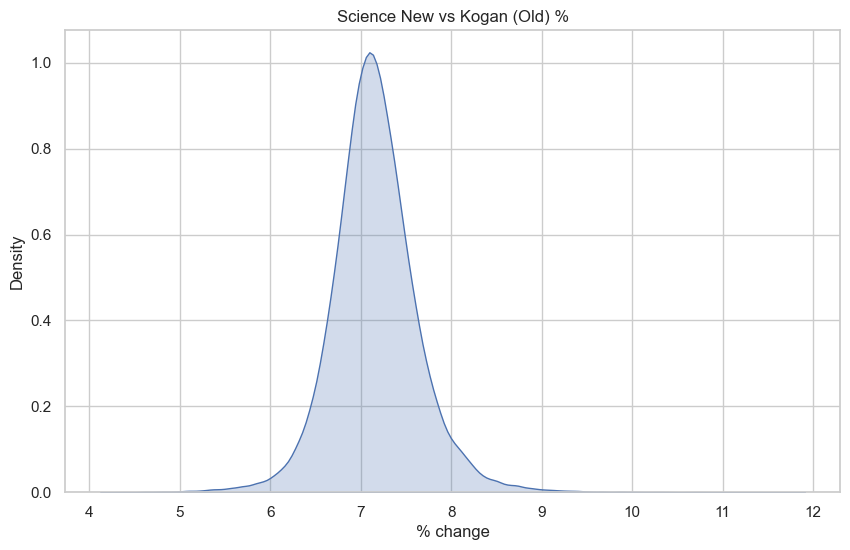

C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1890682356.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data['diff_nonscience'], shade=True)


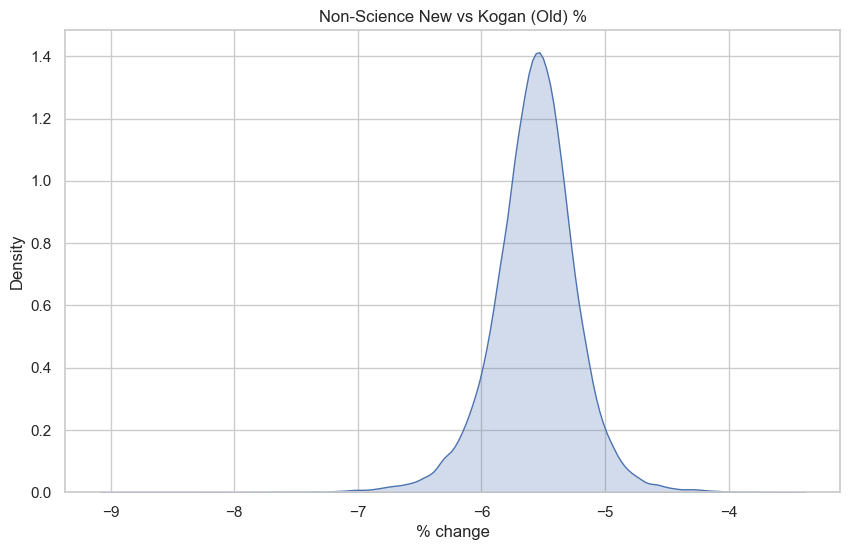

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['diff'], shade=True)
plt.title("Science New vs Kogan (Old) %")
plt.xlabel("% change")
plt.ylabel("Density")
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['diff_nonscience'], shade=True)
plt.title("Non-Science New vs Kogan (Old) %")
plt.xlabel("% change")
plt.ylabel("Density")
plt.show()

In [11]:
# Convert the string column to datetime (without hours, minutes, and seconds)
filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')

# If you want to convert it to a string data type explicitly
filtered_data['date'] = filtered_data['date'].astype(str)

C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\2326752147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\2326752147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = filtered_data['date'].astype(str)


In [12]:
filtered_data

,permno_adj,bdate,date,gvkey,datadate,fyear,naics,sic,ret,npatents,...,sqrt_delta_anyscience,functions_input_anyscience,numerator_anyscience,denominator_anyscience,exp_cond_value_anyscience,economic_value_science,science_new,non_science_new,diff,diff_nonscience
173,10078.0,2873,1991-05-14,012136,1991-06-30,1991.0,334111,3571,-0.006734,2.0,...,0.148771,0.192477,0.391620,0.423684,0.006193,26184366.0,2.601956e+07,2.317261e+07,6.595254,-5.067940
194,10078.0,3242,1992-10-27,012136,1992-06-30,1992.0,334111,3571,0.014815,2.0,...,0.148771,-0.122415,0.395964,0.548715,0.005968,22846318.0,2.267577e+07,1.985674e+07,7.586953,-5.788152
199,10078.0,3037,1992-01-07,012136,1992-06-30,1992.0,334111,3571,0.044248,4.0,...,0.148771,-0.049828,0.398447,0.519870,0.005771,9452883.0,9.385006e+06,8.251410e+06,7.350854,-5.615835
207,10078.0,3294,1993-01-12,012136,1993-06-30,1993.0,334111,3571,-0.016722,4.0,...,0.148771,-0.016507,0.398888,0.506585,0.005053,11065975.0,1.098793e+07,9.678333e+06,7.243435,-5.538339
214,10078.0,3504,1993-11-09,012136,1993-06-30,1993.0,334111,3571,0.005051,7.0,...,0.148771,-0.202015,0.390884,0.580047,0.005505,4293635.0,4.260205e+06,3.713850e+06,7.850214,-5.981171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400589,93436.0,9989,2019-08-13,184996,2019-12-31,2019.0,336111,3711,0.026156,2.0,...,0.148771,0.131905,0.395487,0.447530,0.005636,269620864.0,2.678665e+08,2.378137e+08,6.786210,-5.194481
400590,93436.0,9844,2019-01-15,184996,2019-12-31,2019.0,336111,3711,0.029994,4.0,...,0.148771,-0.053848,0.398364,0.521472,0.006131,207093952.0,2.056037e+08,1.807293e+08,7.369032,-5.620705
400595,93436.0,9969,2019-07-16,184996,2019-12-31,2019.0,336111,3711,-0.004418,2.0,...,0.148771,-0.015973,0.398891,0.506372,0.006026,309539648.0,3.073571e+08,2.707327e+08,7.247601,-5.531927
400601,93436.0,9853,2019-01-29,184996,2019-12-31,2019.0,336111,3711,0.003644,2.0,...,0.148771,-0.041600,0.398597,0.516591,0.006097,355701856.0,3.531589e+08,3.106417e+08,7.329634,-5.591888


In [13]:
#Save Pat Pub Citation Pair File
filename_save =os.path.join(wrd,"Data\kpss_calculation\Multipatent_fromPython_topq_fullSample.dta")
print(filename_save)

filtered_data.to_stata(filename_save)

<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1315721256.py:2: SyntaxWarning: invalid escape sequence '\k'
  filename_save =os.path.join(wrd,"Data\kpss_calculation\Multipatent_fromPython_topq_fullSample.dta")


C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\kpss_calculation\Multipatent_fromPython_topq_fullSample.dta


**Run the stata code**

# Patent with Foreign and Domestic Inventor

In [37]:
# Read the Stata file

#Save Pat Pub Citation Pair File
filename =os.path.join(wrd,"Data\kpss_calculation\patent_pythonallnonusa_invt.dta")
print(filename)

data = pd.read_stata(filename)


#data = pd.read_stata(r"C:\Users\jayho\OneDrive - Duke University\KPSS_Replication\ABF_PatValue_Research\Data\patent_science_python_jay.dta")

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1509671006.py:4: SyntaxWarning: invalid escape sequence '\k'
  filename =os.path.join(wrd,"Data\kpss_calculation\patent_pythonallnonusa_invt.dta")


C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\kpss_calculation\patent_pythonallnonusa_invt.dta


**Change value of Gamma allforeinginvt .0137449 //
Gamma no foreign Invt .0196797 **

In [38]:
from scipy.special import owens_t as scipy_owens_t

def E_science_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(.0153032)-1)
    theta2 = np.sqrt(np.exp( .0199175)-1)
    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator





In [39]:
from scipy.special import owens_t as scipy_owens_t

def E_nonscience_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp( .0199175)-1)
    theta2 = np.sqrt(np.exp(.0153032)-1)

    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator



In [40]:
def calculate_function_science(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    pi =  0.56 
    cond_exp = E_science_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value

def calculate_function_nonscience(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    pi =  0.56 
    
    cond_exp = E_nonscience_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value
    

In [41]:
# Apply the function to each row and create a new column with the result
filtered_data = data[data['pat_allnonusa_invt_mix'] == 1]
filtered_data['allnonusa_new'] = filtered_data.apply(calculate_function_science, axis=1)

filtered_data['nononusa_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)


C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1265458602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['allnonusa_new'] = filtered_data.apply(calculate_function_science, axis=1)
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1265458602.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['nononusa_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)


In [42]:
# Convert the string column to datetime (without hours, minutes, and seconds)
filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')

# If you want to convert it to a string data type explicitly
filtered_data['date'] = filtered_data['date'].astype(str)



C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1623763333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1623763333.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = filtered_data['date'].astype(str)


In [43]:
#Save Pat Pub Citation Pair File
filename_save =os.path.join(wrd,"Data\kpss_calculation\Multipatent_frompythonallnonusa_invt.dta")
print(filename_save)

filtered_data.to_stata(filename_save)

<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1452445671.py:2: SyntaxWarning: invalid escape sequence '\k'
  filename_save =os.path.join(wrd,"Data\kpss_calculation\Multipatent_frompythonallnonusa_invt.dta")


C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\kpss_calculation\Multipatent_frompythonallnonusa_invt.dta


# Patent with large vs Small team

In [44]:
# Read the Stata file

#Save Pat Pub Citation Pair File
filename =os.path.join(wrd,"Data\kpss_calculation\patent_pythonteamsize_topq_invt.dta")
print(filename)

data = pd.read_stata(filename)


#data = pd.read_stata(r"C:\Users\jayho\OneDrive - Duke University\KPSS_Replication\ABF_PatValue_Research\Data\patent_science_python_jay.dta")

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\2767656100.py:4: SyntaxWarning: invalid escape sequence '\k'
  filename =os.path.join(wrd,"Data\kpss_calculation\patent_pythonteamsize_topq_invt.dta")


C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\kpss_calculation\patent_pythonteamsize_topq_invt.dta


In [45]:
from scipy.special import owens_t as scipy_owens_t

def E_science_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(.0251418)-1)
    theta2 = np.sqrt(np.exp(.0165009 )-1)
    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator





In [46]:
from scipy.special import owens_t as scipy_owens_t

def E_nonscience_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(.0165009)-1)
    theta2 = np.sqrt(np.exp(.0251418)-1)

    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator



In [47]:
def calculate_function_science(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']

    pi =  0.56 
    cond_exp = E_science_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value

def calculate_function_nonscience(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    pi =  0.56 
    
    cond_exp = E_nonscience_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value
    

In [48]:
# Apply the function to each row and create a new column with the result
filtered_data = data[data['pat_largeteam_topq_mix'] == 1]
filtered_data['largeteam_new'] = filtered_data.apply(calculate_function_science, axis=1)

filtered_data['smallteam_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)


C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\3064013962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['largeteam_new'] = filtered_data.apply(calculate_function_science, axis=1)
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\3064013962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['smallteam_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)


In [49]:
# Convert the string column to datetime (without hours, minutes, and seconds)
filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')

# If you want to convert it to a string data type explicitly
filtered_data['date'] = filtered_data['date'].astype(str)

C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\2326752147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\2326752147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = filtered_data['date'].astype(str)


In [50]:
#Save Pat Pub Citation Pair File
filename_save =os.path.join(wrd,"Data\kpss_calculation\Multipatent_pythonteamsize_topq_invt.dta")
print(filename_save)

filtered_data.to_stata(filename_save)

<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jayho\AppData\Local\Temp\ipykernel_10680\1782263951.py:2: SyntaxWarning: invalid escape sequence '\k'
  filename_save =os.path.join(wrd,"Data\kpss_calculation\Multipatent_pythonteamsize_topq_invt.dta")


C:\Users\jayho\OneDrive - Duke University\ABF_PatValue_Research\Data\kpss_calculation\Multipatent_pythonteamsize_topq_invt.dta


In [ ]:
stop

**Run Stata Code**

# Patent with science defined as higher than median citations

In [ ]:
# Read the Stata file

#Save Pat Pub Citation Pair File
filename =os.path.join(wrd,"Data\patent_science_python_adj_fullSample.dta")
print(filename)

data = pd.read_stata(filename)


#data = pd.read_stata(r"C:\Users\jayho\OneDrive - Duke University\KPSS_Replication\ABF_PatValue_Research\Data\patent_science_python_jay.dta")

In [ ]:
from scipy.special import owens_t as scipy_owens_t

def E_science_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(.0236494)-1)
    theta2 = np.sqrt(np.exp(.0174315)-1)
    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator





In [ ]:
from scipy.special import owens_t as scipy_owens_t

def E_nonscience_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(.0174315)-1)
    theta2 = np.sqrt(np.exp(.0236494)-1)

    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator



In [ ]:
def calculate_function_science(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    prop_cscience =row['prop_cscience_adj']
    pi =  0.56 
    cond_exp = E_science_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value

def calculate_function_nonscience(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    prop_cscience =row['prop_cscience_adj']
    pi =  0.56 
    
    cond_exp = E_nonscience_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value
    

In [ ]:
# Apply the function to each row and create a new column with the result
filtered_data = data[data['patents_cscience_adj_mixed'] == 1]
filtered_data['science_new'] = filtered_data.apply(calculate_function_science, axis=1)

filtered_data['non_science_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)

filtered_data['diff']= ((filtered_data['science_new']/filtered_data['economic_value_kogan'])-1)*100

filtered_data['diff_nonscience']= ((filtered_data['non_science_new']/filtered_data['economic_value_kogan'])-1)*100

In [ ]:
# Calculate mean
mean_value = filtered_data['diff'].mean()

# Calculate median
median_value = filtered_data['diff'].median()

# Calculate minimum
min_value = filtered_data['diff'].min()

# Calculate maximum
max_value = filtered_data['diff'].max()

# Print the calculated statistics
print("Mean:", mean_value)
print("Median:", median_value)
print("Minimum:", min_value)
print("Maximum:", max_value)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['diff'], shade=True)
plt.title("Science New vs Kogan (Old) %")
plt.xlabel("% change")
plt.ylabel("Density")
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['diff_nonscience'], shade=True)
plt.title("Non-Science New vs Kogan (Old) %")
plt.xlabel("% change")
plt.ylabel("Density")
plt.show()

In [ ]:
# Convert the string column to datetime (without hours, minutes, and seconds)
filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')

# If you want to convert it to a string data type explicitly
filtered_data['date'] = filtered_data['date'].astype(str)

In [ ]:
#Save Pat Pub Citation Pair File
filename_save =os.path.join(wrd,"Data\Multipatent_fromPython_adj_fullSample.dta")
print(filename_save)

filtered_data.to_stata(filename_save)

# Subsample 
**Patent with science defined as higher than median citations**

In [ ]:
# Read the Stata file

#Save Pat Pub Citation Pair File
filename =os.path.join(wrd,"Data\patent_science_python_adj_subsamplee.dta")
print(filename)

data = pd.read_stata(filename)


#data = pd.read_stata(r"C:\Users\jayho\OneDrive - Duke University\KPSS_Replication\ABF_PatValue_Research\Data\patent_science_python_jay.dta")

In [ ]:
from scipy.special import owens_t as scipy_owens_t

def E_science_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(0.018341)-1)
    theta2 = np.sqrt(np.exp(0.0127989)-1)
    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator





In [ ]:
from scipy.special import owens_t as scipy_owens_t

def E_nonscience_estimate(R, sigma_u):
    """
    Estimate E(v|R) using provided expression
    :param R: float
        Input R value
    :param theta1: float
        Parameter theta1
    :param theta2: float
        Parameter theta2
    :param sigma_u: float
        Parameter sigma_u
    :return: float
        Estimated value of E(v|R)
    """
    theta1 = np.sqrt(np.exp(0.0127989)-1)
    theta2 = np.sqrt(np.exp(0.018341)-1)

    s = sigma_u * np.sqrt(1 + theta1**2 + theta2**2)
    
    omega1 = s * np.sqrt(1 + theta2**2) / theta1
    omega2 = s * np.sqrt(1 + theta1**2) / theta2
    
    lambda1 = (theta2 / theta1) * np.sqrt(1 + theta1**2 + theta2**2)
    lambda2 = (theta1 / theta2) * np.sqrt(1 + theta1**2 + theta2**2)
    
    phi = norm.pdf
    Phi = norm.cdf
    
    numerator = (2 * ((1 + theta2 ** 2) * sigma_u ** 2 / omega1) * phi(R / omega1) * Phi(lambda1 / omega1 * R) -
                 2 * theta1 ** 2 * sigma_u ** 2 / omega2 * phi(R / omega2) * Phi(lambda2 / omega2 * R))
    
    denominator = (Phi(R / omega1) - 2 * scipy_owens_t(R / omega1, lambda1) +
                   Phi(R / omega2) - 2 * scipy_owens_t(R / omega2, lambda2))
    
    return (theta1 ** 2 / (1 + theta1 ** 2 + theta2 ** 2)) * R + numerator / denominator



In [ ]:
def calculate_function_science(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    prop_cscience =row['prop_cscience_adj']
    pi =  0.56 
    cond_exp = E_science_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value

def calculate_function_nonscience(row):
    R = row['abnret_d02']
    sigma_u = row['vol_e_new']
    sigma_u = sigma_u**(1/2)
    mktvalue = row['mktvalue']
    npatents = row['npatents']
    prop_cscience =row['prop_cscience_adj']
    pi =  0.56 
    
    cond_exp = E_nonscience_estimate(R,sigma_u)
    value=((cond_exp * mktvalue) / (1 - pi)) / (npatents)
    return value
    

In [ ]:
# Apply the function to each row and create a new column with the result
filtered_data = data[data['patents_cscience_adj_mixed'] == 1]
filtered_data['science_new'] = filtered_data.apply(calculate_function_science, axis=1)

filtered_data['non_science_new'] = filtered_data.apply(calculate_function_nonscience, axis=1)

filtered_data['diff']= ((filtered_data['science_new']/filtered_data['economic_value_kogan'])-1)*100

filtered_data['diff_nonscience']= ((filtered_data['non_science_new']/filtered_data['economic_value_kogan'])-1)*100

In [ ]:
# Calculate mean
mean_value = filtered_data['diff'].mean()

# Calculate median
median_value = filtered_data['diff'].median()

# Calculate minimum
min_value = filtered_data['diff'].min()

# Calculate maximum
max_value = filtered_data['diff'].max()

# Print the calculated statistics
print("Mean:", mean_value)
print("Median:", median_value)
print("Minimum:", min_value)
print("Maximum:", max_value)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['diff'], shade=True)
plt.title("Science New vs Kogan (Old) %")
plt.xlabel("% change")
plt.ylabel("Density")
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Create the density plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_data['diff_nonscience'], shade=True)
plt.title("Non-Science New vs Kogan (Old) %")
plt.xlabel("% change")
plt.ylabel("Density")
plt.show()

In [ ]:
# Convert the string column to datetime (without hours, minutes, and seconds)
filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d%b%Y')

# If you want to convert it to a string data type explicitly
filtered_data['date'] = filtered_data['date'].astype(str)

In [ ]:
#Save Pat Pub Citation Pair File
filename_save =os.path.join(wrd,"Data\Multipatent_fromPython_adj_subsamplee.dta")
print(filename_save)

filtered_data.to_stata(filename_save)